In [1]:
# Import:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # include parent directory in the path
from toolbox.experiment import Experiment
from toolbox.SINDy import SINDy
from toolbox.symbolic_SINDy import symbolic_SINDy
from toolbox.cusum import CUSUM
from toolbox.auxiliary_functions import set_param_freq
from data import SINDy_data, equations

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


In [2]:
# Select ODE:
ode_name = 'TVVdpODE2'
ode_param = "5.0,0.5,3.14"
freq = 20
ode_param, freq = set_param_freq(ode_param, freq)
ode = equations.get_ode(ode_name, ode_param)

# Parameters:
freq_SR = 20
n_sample = 50 
noise_ratio = 0.01
seed = 100 
n_seed = 1 
dt = 1 / freq
dim_x = 3
dim_k = 0
SW_length = 15 # SINDy sliding window length
SW_length_SR = 10 # SR sliding window length
H = 60 # length of the experiment
lazy = True # if True, we do not recompute the building blocks with SR
symbolic = True # if True, SR call is allowed, otw. simple SINDy is used throughout the whole experiment

# CUSUM parameters:
N = 8
eps = 0.1
threshold = 1.

In [ ]:
# # Generate data: (16min 46.8sec)
# X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k, 0, H)
# print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
# print(feature_names)

# # Save data:
# file_path = 'saved/data/TVVdpODE2_data.pkl'
# os.makedirs(os.path.dirname(file_path), exist_ok=True)
# with open(file_path, 'wb') as f:
#     dill.dump((X_list, dX_list, param_list, feature_names), f)

(50, 1600, 3) (50, 1600, 3) (0,)
['X0', 'X1', 'X2']


In [3]:
# Load data:
file_path = 'saved/data/TVVdpODE2_data.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

In [4]:
# Initialize experiment and model discovery methods:
exp = Experiment(ode, ode_param, freq_SR, n_sample, noise_ratio, seed, n_seed, dt, dim_x, dim_k, SW_length, SW_length_SR, H, lazy, symbolic)

cusum = CUSUM(N, eps, threshold)

SINDy_method = SINDy(degree=3, include_bias=True, threshold=0.4)

SR_method = 'SR-T' # symbolic regression method chosen 
x_id = 0  # equation to be identified by SR 
symbolic_SINDy_method = symbolic_SINDy(SR_method, x_id=0, degree=3, product=True, threshold=0.3, penalty=14.6, max_patience=10)

In [5]:
# Run the experiment:

while exp.T <= exp.H:

    print(f't: {exp.T}')
    # update time-window:
    X_list_t = [x[(exp.T0*freq):(exp.T*freq)] for x in X_list]
    dX_list_t = [dx[(exp.T0*freq):(exp.T*freq)] for dx in dX_list]  

    exp.step_forward(SINDy_method, symbolic_SINDy_method, cusum, X_list_t, dX_list_t, param_list, feature_names, CP_threshold=1.36)
    # building block search time: .m .s
    # total time: 37m 16.6s

t: 15
SINDy model:
(X0)' = 4.725 X0 + -1.223 X1 + -4.695 X0 X1^2
(X1)' = 1.006 X0
(X2)' = 1.004 1
Model complexity:  5
Lasso penalty:  12.652139841368596
RMSE:  0.7002838188082567

t: 16
Time:  16
CUSUM quantity:  0
CUSUM quantity:  0
Change point: False
RMSE:  0.8123406335344248

t: 17
Time:  17
CUSUM quantity:  0
CUSUM quantity:  0
Change point: False
RMSE:  0.8729831008245842

t: 18
Time:  18
CUSUM quantity:  0
CUSUM quantity:  0
Change point: False
RMSE:  0.6081486383371331

t: 19
Time:  19
CUSUM quantity:  0
CUSUM quantity:  0
Change point: False
RMSE:  0.9561811528808322

t: 20
Time:  20
CUSUM quantity:  0
CUSUM quantity:  0
Change point: False
RMSE:  0.5857402198424799

t: 21
Time:  21
CUSUM quantity:  0
CUSUM quantity:  0
Change point: False
RMSE:  0.4009069002811927

t: 22
Time:  22
CUSUM quantity:  0
CUSUM quantity:  0
Change point: False
RMSE:  1.0092705727647449

t: 23
Time:  23
CUSUM quantity:  0.17081069986675532
CUSUM quantity:  0
Change point: False
RMSE:  1.11095645704

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


KeyboardInterrupt: 

In [ ]:
# TODO: mettere finestra di 40 sec.

In [ ]:
exp.plot_RMSE() # forse meglio in log scale

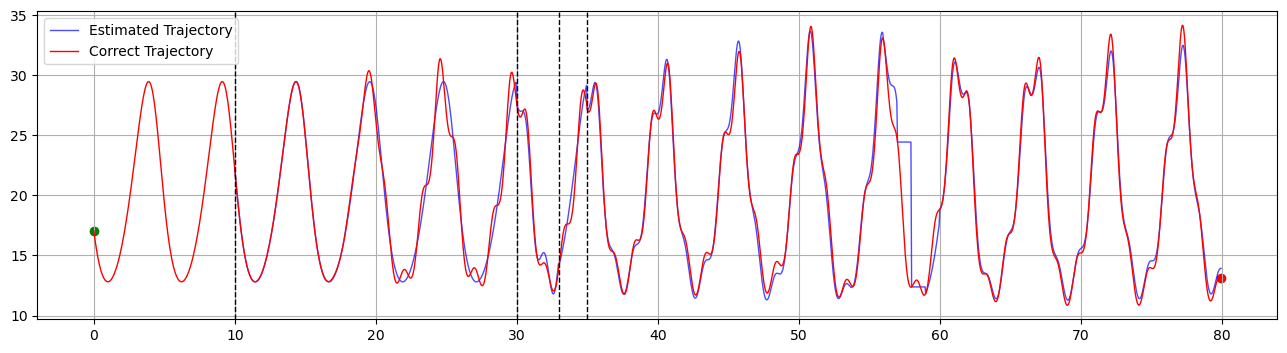

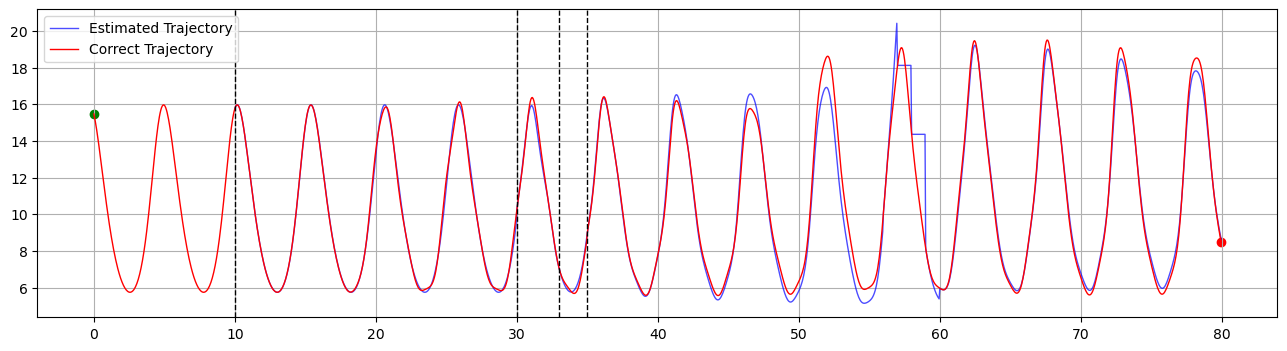

In [46]:
from data.SINDy_data import evaluate_RMSE_d, evaluate_traj_d_1D
start = [17.0514206, 15.47072179, 0.]

x_id = 0

plot_times_1 = exp.turning_points.copy() 
plot_models_1 = exp.model_history.copy()
plot_times_1.append(exp.H)
plot_models_1.insert(0, plot_models_1[0])

xt_true1 = []
pred_list1 = []
time_vector_1 = np.arange(0, plot_times_1[-1], exp.dt)
time_vector_2 = np.arange(plot_times_1[1], plot_times_1[-1], exp.dt)
for i in range(len(plot_models_1)):
    xt_true_i, pred_i = evaluate_traj_d_1D(plot_models_1[i], exp.ode, 20, 1, start, start, plot_times_1[i], plot_times_1[i+1], x_id, exp.dim_x, exp.dim_k, plot=False)
    if i == 0:
        xt_true1 = np.concatenate((xt_true1, xt_true_i), axis = 0)
    else: 
        xt_true1 = np.concatenate((xt_true1, xt_true_i), axis = 0)
        pred_list1 = np.concatenate((pred_list1, pred_i), axis = 0)


fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(time_vector_2, pred_list1, color='blue', linewidth=1.0, alpha=0.7, label='Estimated Trajectory')
ax.plot(time_vector_1, xt_true1, color='red', linewidth=1.0, label='Correct Trajectory')
ax.scatter(time_vector_1[-1], xt_true1[-1], color='red')
ax.scatter(time_vector_1[0], xt_true1[0], color='green')
ax.legend()
ax.grid()
for x in [plot_times_1[1], plot_times_1[2], plot_times_1[3], plot_times_1[4]]: 
    ax.axvline(x=x, color='black', linestyle='--', linewidth=1.0, label='Vertical Line' if x == 1 else "")



x_id = 1

plot_times_1 = exp.turning_points.copy() 
plot_models_1 = exp.model_history.copy()
plot_times_1.append(exp.H)
plot_models_1.insert(0, plot_models_1[0])

xt_true2 = []
pred_list2 = []
time_vector_1 = np.arange(0, plot_times_1[-1], exp.dt)
time_vector_2 = np.arange(plot_times_1[1], plot_times_1[-1], exp.dt)
for i in range(len(plot_models_1)):
    xt_true_i, pred_i = evaluate_traj_d_1D(plot_models_1[i], exp.ode, 20, 1, start, start, plot_times_1[i], plot_times_1[i+1], x_id, exp.dim_x, exp.dim_k, plot=False)
    if i == 0:
        xt_true2 = np.concatenate((xt_true2, xt_true_i), axis = 0)
    else: 
        xt_true2 = np.concatenate((xt_true2, xt_true_i), axis = 0)
        pred_list2 = np.concatenate((pred_list2, pred_i), axis = 0)


fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(time_vector_2, pred_list2, color='blue', linewidth=1.0, alpha=0.7, label='Estimated Trajectory')
ax.plot(time_vector_1, xt_true2, color='red', linewidth=1.0, label='Correct Trajectory')
ax.scatter(time_vector_1[-1], xt_true2[-1], color='red')
ax.scatter(time_vector_1[0], xt_true2[0], color='green')
ax.legend()
ax.grid()
for x in [plot_times_1[1], plot_times_1[2], plot_times_1[3], plot_times_1[4]]:  
    ax.axvline(x=x, color='black', linestyle='--', linewidth=1.0, label='Vertical Line' if x == 1 else "")

## Plot report 

- Plot della ground truth trajectory con le stelline in prossimità dei change point reali (rosso)
- Plot con tutto insieme

In [76]:
# Real trajectory noise free
xt_true = np.stack((xt_true1, xt_true2), axis = 0) # shape (2, 1600)
# Real trajectory with noise
xt_true_noise = np.array(X_list)[0, :1600, :2].transpose() # shape (2, 1600)
# Both associated with 
t1 = time_vector_1

# On-the-fly model prediction
xt_pred = np.stack((pred_list1, pred_list2), axis = 0)
# Associated with
t2 = time_vector_2

# Model and change point detected
models = plot_models_1.copy()
change_model = plot_times_1.copy()
change_real = [20, 50]

In [92]:
# Save experiment:
file_path = 'saved/experiment/TVLvODE2_d_exp.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((xt_true, xt_true_noise, t1, xt_pred, t2, models, change_model, change_real), f)

In [ ]:
# Load data:
file_path = 'saved/data/TVLvODE2_d_data.pkl'
with open(file_path, 'rb') as f:
    xt_true, xt_true_noise, t1, xt_pred, t2, models, change_model, change_real = dill.load(f)

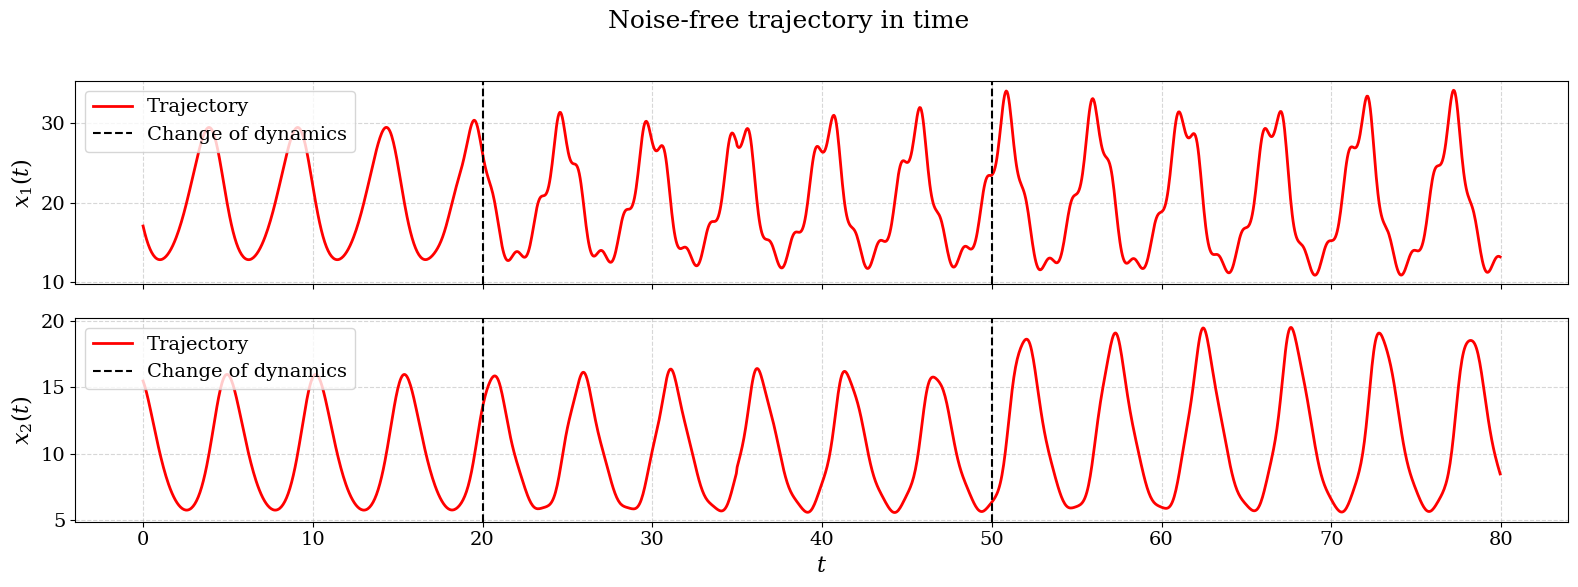

<Figure size 640x480 with 0 Axes>

In [77]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "dejavuserif",  # oppure 'cm' per Computer Modern
    "font.size": 14
})

fig, axes = plt.subplots(2, 1, figsize=(16, 6), sharex=True)

axes[0].plot(t1, xt_true[0, :], color='red', lw=2, label='Trajectory')
axes[0].set_ylabel(r"$x_1(t)$", fontsize=16)
axes[0].grid(True, linestyle='--', alpha=0.5)

axes[1].plot(t1, xt_true[1, :], color='red', lw=2, label='Trajectory')
axes[1].set_xlabel(r"$t$", fontsize=16)
axes[1].set_ylabel(r"$x_2(t)$", fontsize=16)
axes[1].grid(True, linestyle='--', alpha=0.5)

axes[0].axvline(x=change_real[0], color='k', linestyle='--', lw=1.5, label='Change of dynamics')
axes[1].axvline(x=change_real[0], color='k', linestyle='--', lw=1.5, label='Change of dynamics')

axes[0].axvline(x=change_real[1], color='k', linestyle='--', lw=1.5)
axes[1].axvline(x=change_real[1], color='k', linestyle='--', lw=1.5)

axes[0].legend()
axes[1].legend()

fig.suptitle("Noise-free trajectory in time", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


plt.tight_layout()
plt.show()


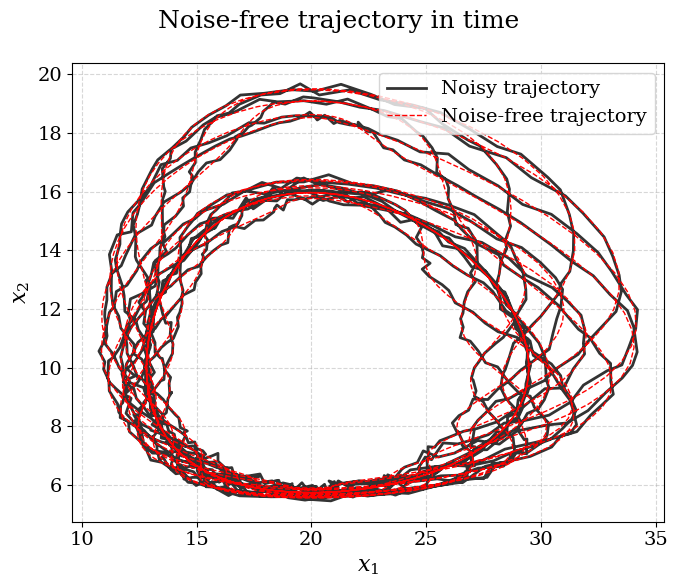

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Impostazioni grafiche coerenti
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "dejavuserif",  # font matematico serif
    "font.size": 14
})

fig, ax = plt.subplots(figsize=(7, 6))

# Traiettoria rumorosa
ax.plot(xt_true_noise[0, :], xt_true_noise[1, :],
        color='black', lw=2, label='Noisy trajectory', alpha = 0.8)

# Traiettoria noise-free
ax.plot(xt_true[0, :], xt_true[1, :],
        color='red', lw=1, linestyle='--', label='Noise-free trajectory')

# Etichette e dettagli
ax.set_xlabel(r"$x_1$", fontsize=16)
ax.set_ylabel(r"$x_2$", fontsize=16)

fig.suptitle("Noise-free trajectory in time", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])

ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()


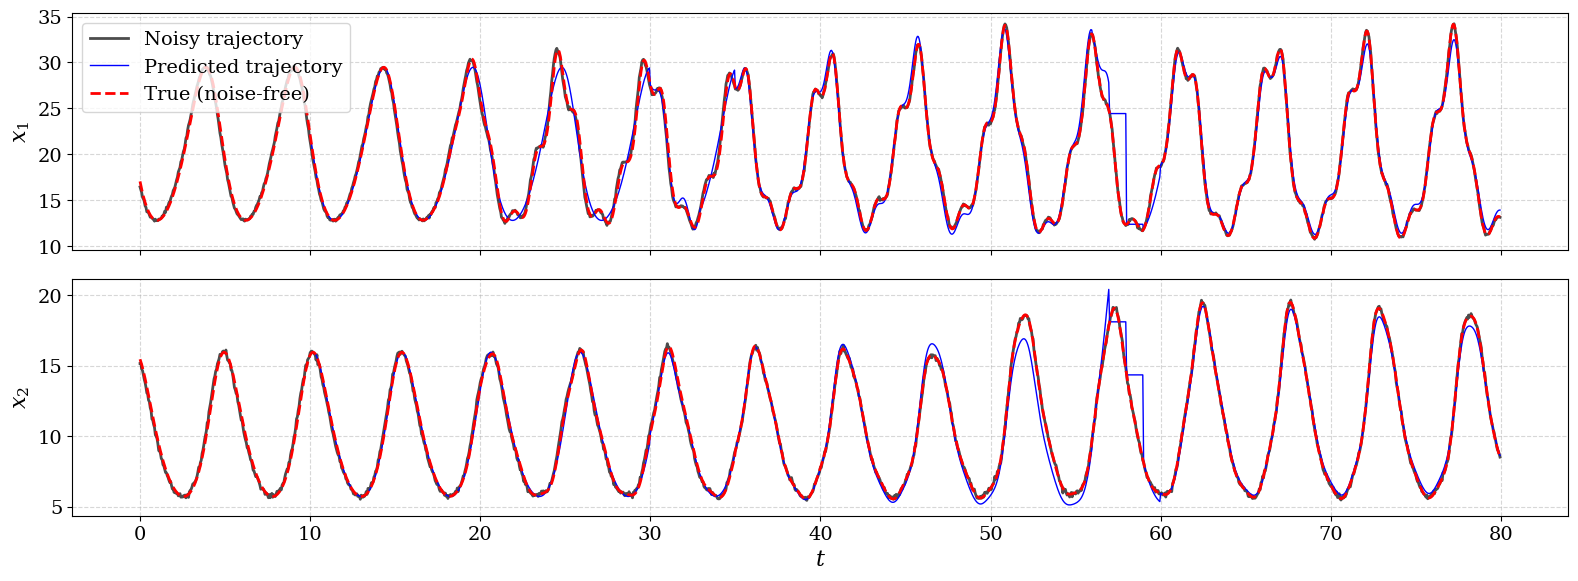

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Impostazioni grafiche generali
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "dejavuserif",
    "font.size": 14
})

fig, axes = plt.subplots(2, 1, figsize=(16, 6), sharex=True)

# === x1(t) ===
axes[0].plot(t1, xt_true_noise[0, :], color='black', lw=2, alpha=0.7, label='Noisy trajectory')
axes[0].plot(t2, xt_pred[0, :], color='blue', lw=1, label='Predicted trajectory')
axes[0].plot(t1, xt_true[0, :], color='red', lw=2, linestyle='--', label='True (noise-free)')
axes[0].set_ylabel(r"$x_1$", fontsize=16)
axes[0].legend(loc='best')
axes[0].grid(True, linestyle='--', alpha=0.5)

# === x2(t) ===
axes[1].plot(t1, xt_true_noise[1, :], color='black', lw=2, alpha=0.7, label='Noisy trajectory')
axes[1].plot(t2, xt_pred[1, :], color='blue', lw=1, label='Predicted trajectory')
axes[1].plot(t1, xt_true[1, :], color='red', lw=2, linestyle='--', label='True (noise-free)')
axes[1].set_ylabel(r"$x_2$", fontsize=16)
axes[1].set_xlabel(r"$t$", fontsize=16)
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
# Plot dei quattro coefficienti nel tempo 

Commento dei risultati:
- Scelta del modello -> per essere beccata la dinamica deve essere chiara alla SR, non confusa con rumore e determinante nella traiettoria. Variazioni lente dei parametri non possono essere mai beccate su finestre temporali ragionevoli con questo problema.
- Scelta numero di generazioni -> avere migliore stima delle costanti: la dinamica tra 5.028 e 5.007 è completamente diversa in termini di rmse
- Testata la capacità di aggiustarsi anche quando fitta modelli  piu o meno sbagliati influenzati da transitori: se il building block ce prima o poi la dinamica vera viene catturata
- Lo switch -> mette in crisi il modello perche causa un transitorio -> prova a fittare un modello con i blocchi che ha (che sono giusti) ma non ne trova mai un modello capace di spiegare la dinamica. questo forza il modello a cercare nuovi blocchi, abbastanza lontano dal transitorio li ritrova e si sistema.
- Lo switch è stato introdotto per testare la capacità della SR di ritrovare trovare il blocco mancante. In generale si osserva che in base al punto di ricerca non sempre trova il blocco corretto

- T = 56: sin(0.5008226879169348*X2) -> NON TROVA patience = 4
- T = 57: sin(5.85685419176154*X2) -> NON TROVA patience = 5
- T = 58: sin(5.068949033687468*sin(X2)) patience = 6
- T = 59: sin(5.448175735771112*sin(X2)) patience = 7
- T = 60 QUI trova tanti blocchi potenziali

- sin(4.997271008241834*X2)
- sin(5.102140407099291*X2)
- sin(5.010848520737575*X2)

- T = 61: sin(5.33594343872588*X2)

- per altri valori di T il blocco decisivo NON viene trovato vista la natura complessa del problema. Tipicamente viene trovato nella prossimita dell'intervalli decimali in cui non cerca anche sfasamenti

- Nota inoltre che anche se da un punto di vista teorico gli altri blocchi trovati restituiscono soluzioni che sono concettualmente corrette per descrivere la dinamica (a volte 5.028, altre 5.20), capita che gli altri blocchi trovati da SR generino localmente con RMSE piu basso e vengono preferite sistematicamente, ma i questi modelli fittati non sono affatto stabili: ogni 2 secondi ce una nuova ricerca del blocco tra quelli disponibili, ma quelli 'giusti' continuano a generare errori troppo alti

- Esperimento positivo che spiega la forza dell'approcio: è stato identificato un termine che a priori non verrebbe mai considerato in SINDy. La generalizzazione pero è obiettivamente complessa. bisogna sempre valutare trade off tra finestra temporale, pazienza e fit -> realisticamente è difficile trovare in modo obiettivo un buon compromesso. Inoltre aggiungendo ulteriore rumore l'identificazione diventa ancora piu complessa.

- Nota infine che la SR non riesce mai da sola a beccare la dinamica corretta, tende sempre a overfittare questa traiettoria. Da qui l'idea di alzare la regolarizzazione sul fit: avere meno blocchi ma determinanti. Fortunatamente poi, estraendo i building blocks e regolarizzando con SINDy riusciamo a ottenere una soluzione parsimoniosa e interpretabile del fenomeno, che si avvicina notevolmente alla dinamica ground truth.

- Nota sulla costante trovata nei modelli di SINDt: seppur piccola, e limitata dall'altro termine in piu in fase con l'oscillazione, sul lungo periodo fa in modo che ogni ciclo la traiettoria stimata si allarghi leggermente.